In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [8]:
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [104]:
file = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20250103/sphere_20250103_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

file = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20250103_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]

    fout.close()

In [497]:
from scipy.special import erf
def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

In [105]:
def expo_corrected(x, b, xi, eff_coefs=None):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        expo_eff_truncated = eff_xx * np.exp(-1 * (xx) / xi) / xi
    else:
        expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < b] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.exp(-1 * (x) / xi) / xi
    else:
        ret = np.exp(-1 * (x) / xi) / xi
    ret[x < b] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

def half_gaus_mod(x, mu, m, n):
    xx = np.linspace(0, 50000, 50000)
    sigma = m * xx + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    sigma_x = m * x + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

In [284]:
def nll(alpha, mu, m, n, b, xi, bc, hist, eff_coefs=None):
    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50


    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [304]:
from scipy.optimize import minimize

ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999068, 378, 5.6e-2, 142, 1414, 140],
               method='Nelder-Mead',
               bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1500), (90, 160)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.01,
                        }
               )

# res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999, 200, 5e-2, 180, 1400, 120],
#                method='COBYQA',
#                bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1600), (90, 160)],
#                tol=1e-6,
#                options={'disp' : True,
#                         'maxiter': 10000,
#                         'maxfev': 10000,
#                         'scale': True,
#                         }
#                )

param_nodm = res.x
nll_nodm   = res.fun

Optimization terminated successfully.
         Current function value: -3333418131.976399
         Iterations: 416
         Function evaluations: 796


In [300]:
def hist_fit_likelihood(bcs, ntot, alpha, mu, m, n, b, xi):
    return ntot * 50 * (alpha * half_gaus_mod(bcs, mu, m, n) + (1 - alpha) * expo_corrected(bcs, b, xi, eff_coefs))

def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])

    ntot = np.sum(hist)
    alpha, mu, m, n, b, xi = res_x

    idx = bc > 800
    hist_norm = n_window * scaling

    hist_fit_ml = hist_fit_likelihood(bc[idx], np.sum(hist), *res_x)

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, 800, color='#B0C4DE', alpha=0.5)
    ax.errorbar(bc[idx], hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)

    ax.plot(bc[idx], hist_fit_ml, '--', color='#DC143C', label='Gaussian + exponential (ML)')

    xx2 = np.linspace(820, 10000, 500)
    gaus_hist = ntot * 50 * alpha * half_gaus_mod(xx2, mu, m, n)
    ax.fill_between(xx2, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(b, 10000, 500)
    expo_hist = ntot * 50 * (1 - alpha) * expo_corrected(xx1, b, xi, eff_coefs=None)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')

    ax.set_xlim(0, 6000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, 800, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 6000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/3987666047.py:52: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')


/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/3987666047.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/3987666047.py:45: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual / $\\sigma_{\\mathrm{stat}}$'>],
       dtype=object))

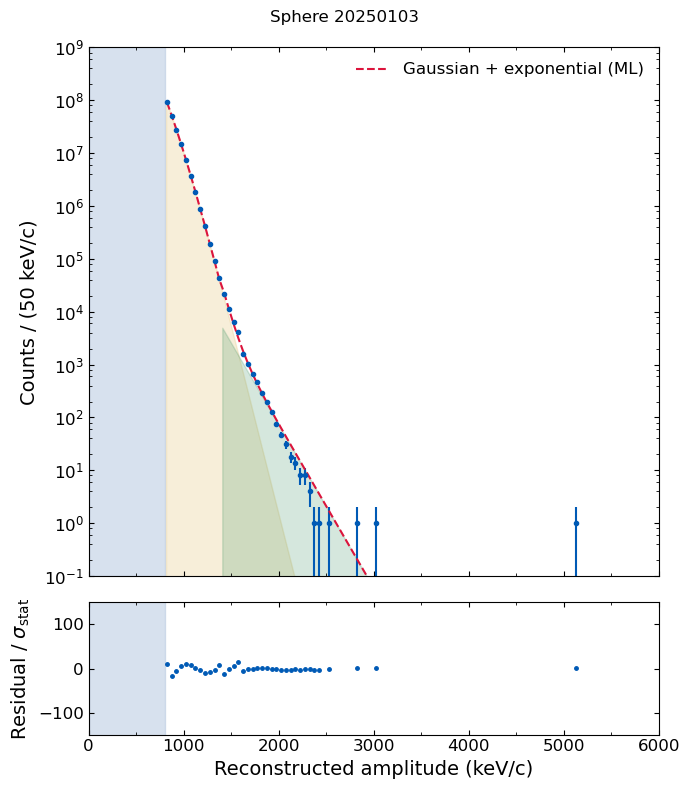

In [307]:
plot_likelihood_fit(bc, hist, res.x)

In [481]:
def read_dm_rate(mphi, mx, alpha):
    R_um       = 0.083
    file = f'/Users/yuhan/work/nanospheres/data/dm_rate/mphi_1e+00/drdqz_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq = drdq_npz['bc_kev']
    drdqzn = drdq_npz['drdqzn']
    
    return qq, drdqzn

def nll_dm(alpha, mu, m, n, b, xi, bc, hist, eff_coefs, mphi, mx, alpha_n, hist_norm):
    qq, drdqzn = read_dm_rate(mphi, mx, alpha_n)
    eff_qq = func2(qq, *eff_coefs)
    hist_dm = eff_qq * drdqzn * hist_norm

    # For large dm couplings that give large kicks
    # zero pad the actual measured histogram
    if qq.size > bc.size:
        hist = np.pad(hist, (0, qq.size - bc.size))
        bc = qq

    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    # DM events are fixed so profile over other parameters
    ntot = np.sum(hist) - np.sum(hist_dm)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    # No correctiion for efficiency for the background
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50 + hist_dm[idx]

    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))

def nll_dm_scaled(alpha, mu, m, n, b, xi, q_scale, n_scale,
                  bc, hist, eff_coefs, mphi, mx, alpha_n, hist_norm):
    
    # Rescale DM model to account for uncertainties in
    # E field and neutron number
    # Multiply `drdqzn` by `q_scale` to account for normalization
    # against the scaled bin width
    # Assume dr/dq scales with n_neutron**2
    qq, drdqzn = read_dm_rate(mphi, mx, alpha_n)
    qq_scaled = qq * q_scale
    drdqzn_scaled = np.interp(qq_scaled, qq, drdqzn*q_scale, left=0, right=0) * n_scale**2

    eff_qq = func2(qq_scaled, *eff_coefs)
    hist_dm = eff_qq * drdqzn_scaled * hist_norm

    # For large dm couplings that give large kicks
    # zero pad the actual measured histogram
    if qq.size > bc.size:
        hist = np.pad(hist, (0, qq.size - bc.size))
        bc = qq

    idx = qq > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    # DM events are fixed so profile over other parameters
    ntot = np.sum(hist) - np.sum(hist_dm)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    # No correctiion for efficiency for the background
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50 + hist_dm[idx]

    sigma_q = 0.05
    sigma_n = np.sqrt(3) * 0.054
    gaus_term = (q_scale - 1)**2 / (2 * sigma_q**2)  # 5% uncertainty as sigma
    neut_term = (n_scale - 1)**2 / (2 * sigma_n**2)

    return np.sum(np.nan_to_num(mui - ni * np.log(mui))) + gaus_term + neut_term

In [482]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi = 1

In [357]:
nlls = np.empty((40, 40))
for i, mx in enumerate(mx_list):
    print(fr'Working on $M_x=$ {mx:.2f} GeV')

    for j, alpha in enumerate(alpha_list):
        args = (bc, hist, eff_coefs, mphi, mx, alpha, hist_norm)
        res = minimize(fun=lambda x: nll_dm_scaled(*x, *args), x0=[0.999999068, 378, 5.6e-2, 142, 1414, 140, 1, 1],
                method='Nelder-Mead',
                bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1500), (90, 160), (0.9, 1.1), (0.8, 1.2)],
                options={'disp' : False,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.01,
                        }
                )
        if res.success:
            nlls[i, j] = res.fun
        else:
            nlls[i, j] = np.nan


Working on $M_x=$ 0.01 GeV
Working on $M_x=$ 0.02 GeV
Working on $M_x=$ 0.02 GeV
Working on $M_x=$ 0.03 GeV
Working on $M_x=$ 0.05 GeV
Working on $M_x=$ 0.08 GeV
Working on $M_x=$ 0.12 GeV
Working on $M_x=$ 0.18 GeV
Working on $M_x=$ 0.27 GeV
Working on $M_x=$ 0.41 GeV
Working on $M_x=$ 0.62 GeV
Working on $M_x=$ 0.94 GeV
Working on $M_x=$ 1.43 GeV
Working on $M_x=$ 2.15 GeV
Working on $M_x=$ 3.26 GeV
Working on $M_x=$ 4.92 GeV
Working on $M_x=$ 7.44 GeV
Working on $M_x=$ 11.25 GeV
Working on $M_x=$ 17.01 GeV
Working on $M_x=$ 25.72 GeV
Working on $M_x=$ 38.88 GeV
Working on $M_x=$ 58.78 GeV
Working on $M_x=$ 88.86 GeV
Working on $M_x=$ 134.34 GeV
Working on $M_x=$ 203.09 GeV
Working on $M_x=$ 307.03 GeV
Working on $M_x=$ 464.16 GeV
Working on $M_x=$ 701.70 GeV
Working on $M_x=$ 1060.82 GeV
Working on $M_x=$ 1603.72 GeV
Working on $M_x=$ 2424.46 GeV
Working on $M_x=$ 3665.24 GeV
Working on $M_x=$ 5541.02 GeV
Working on $M_x=$ 8376.78 GeV
Working on $M_x=$ 12663.80 GeV
Working on $M_x=$

In [483]:
mx_list_1    = np.logspace(0, 1, 10)
alpha_list_1 = np.logspace(-7, -3, 20)

nlls_1 = np.empty((10, 20))
for i, mx in enumerate(mx_list_1):
    print(fr'Working on $M_x=$ {mx:.2f} GeV')

    for j, alpha in enumerate(alpha_list_1):
        args = (bc, hist, eff_coefs, mphi, mx, alpha, hist_norm)
        res = minimize(fun=lambda x: nll_dm_scaled(*x, *args), x0=[0.999999068, 378, 5.6e-2, 142, 1414, 140, 1, 1],
                method='Nelder-Mead',
                bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1500), (90, 160), (0.9, 1.1), (0.8, 1.2)],
                options={'disp' : False,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.01,
                        }
                )
        if res.success:
            nlls_1[i, j] = res.fun
        else:
            nlls_1[i, j] = np.nan


Working on $M_x=$ 1.00 GeV
Working on $M_x=$ 1.29 GeV
Working on $M_x=$ 1.67 GeV
Working on $M_x=$ 2.15 GeV
Working on $M_x=$ 2.78 GeV
Working on $M_x=$ 3.59 GeV
Working on $M_x=$ 4.64 GeV
Working on $M_x=$ 5.99 GeV
Working on $M_x=$ 7.74 GeV
Working on $M_x=$ 10.00 GeV


In [496]:
np.savez('./profile_nlls/profile_nlls_1ev_0.npz', mx=mx_list, alpha=alpha_list, nll=nlls)
np.savez('./profile_nlls/profile_nlls_1ev_1.npz', mx=mx_list_1, alpha=alpha_list_1, nll=nlls_1)

In [430]:
def smooth_nlls(alpha_list, nlls):
    _res = np.copy(nlls)
    for i, nll in enumerate(_res):
        if i == 0:
            continue

        if nll < _res[i-1]:
            if i == (_res.size - 1):
                _res[i] = _res[i - 1]
            else:
                _res[i] = np.interp(alpha_list[i], [alpha_list[i-1], alpha_list[i+1]], [_res[i-1], _res[i+1]])
    return _res

def get_upper_alpha(alpha_list, nlls):
    idx_ml = np.argmin(nlls)

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = alpha_list >= alpha_list[idx_ml]
    if np.sum(idx_search) == 0:
        return np.nan

    delta_nlls_smoothed = smooth_nlls(alpha_list[idx_search], nlls[idx_search] - nlls[idx_ml])

    return np.interp(3.841, 2*delta_nlls_smoothed, alpha_list[idx_search], left=np.nan, right=np.nan)

In [502]:
nlls_0_1ev_file = np.load(r'/Users/yuhan/work/nanospheres/impulse_analysis/profile_nlls/profile_nlls_1e-01ev_0.npz')
nlls_0_1ev = nlls_0_1ev_file['nll']
mx_list_0_1ev, alpha_list_0_1ev = nlls_0_1ev_file['mx'], nlls_0_1ev_file['alpha']

alpha_upper_0_1ev = np.empty(40)
for i in range(40):
    alpha_upper_0_1ev[i] = get_upper_alpha(alpha_list_0_1ev, nlls_0_1ev[i])

In [516]:
nlls_10ev_file = np.load(r'/Users/yuhan/work/nanospheres/impulse_analysis/profile_nlls/profile_nlls_1e+01ev_0.npz')
nlls_10ev = nlls_10ev_file['nll']
mx_list_10ev, alpha_list_10ev = nlls_10ev_file['mx'], nlls_10ev_file['alpha']

alpha_upper_10ev = np.empty(40)
for i in range(40):
    alpha_upper_10ev[i] = get_upper_alpha(alpha_list_10ev, nlls_10ev[i])

In [518]:
nlls_0_01ev_file = np.load(r'/Users/yuhan/work/nanospheres/impulse_analysis/profile_nlls/profile_nlls_1e-02_0.npz')
nlls_0_01ev = nlls_0_01ev_file['nll']
mx_list_0_01ev, alpha_list_0_01ev = nlls_0_01ev_file['mx'], nlls_0_01ev_file['alpha']

alpha_upper_0_01ev = np.empty(40)
for i in range(40):
    alpha_upper_0_01ev[i] = get_upper_alpha(alpha_list_0_01ev, nlls_0_01ev[i])

In [485]:
alpha_upper_1 = np.empty(10)
for i in range(10):
    alpha_upper_1[i] = get_upper_alpha(alpha_list_1, nlls_1[i])

alpha_upper = np.empty(40)
for i in range(40):
    alpha_upper[i] = get_upper_alpha(alpha_list, nlls[i])

In [513]:
print(alpha_upper_10ev)

[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 7.47265402e-05 1.53954282e-06
 1.62878440e-06 1.58714857e-06 2.74005529e-06 3.35943092e-06
 4.67149336e-06 8.25154126e-06 2.91344209e-05            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 3.49208006e-05            nan 4.99134144e-06
 5.07057602e-06 1.94545086e-05            nan            nan]


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/2604679808.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mx_all_sorted[idx_notnan], alpha_upper_all_sorted[idx_notnan], 'cadetblue', label='$m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/2604679808.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mx_list_0_1ev[idx_notnan_0_1ev], alpha_upper_0_1ev[idx_notnan_0_1ev], 'b', label='$m_\phi$ = 0.1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_77135/2604679808.py:14: SyntaxWarning: invalid escape seq

Text(0, 0.5, 'Upper limit on $\\alpha_n$')

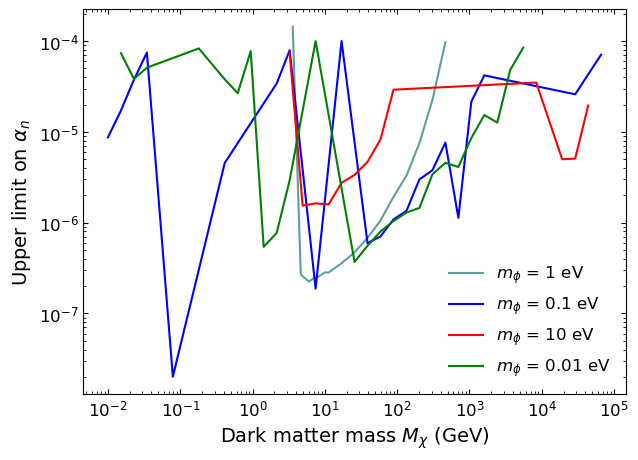

In [520]:
mx_all = np.concatenate([mx_list, mx_list_1])
alpha_upper_all = np.concatenate([alpha_upper, alpha_upper_1])

mx_all_sorted, idx_sorted = np.unique(mx_all, return_index=True)
alpha_upper_all_sorted = alpha_upper_all[idx_sorted]

idx_notnan = np.logical_not(np.isnan(alpha_upper_all_sorted))
plt.plot(mx_all_sorted[idx_notnan], alpha_upper_all_sorted[idx_notnan], 'cadetblue', label='$m_\phi$ = 1 eV')

idx_notnan_0_1ev = np.logical_not(np.isnan(alpha_upper_0_1ev))
plt.plot(mx_list_0_1ev[idx_notnan_0_1ev], alpha_upper_0_1ev[idx_notnan_0_1ev], 'b', label='$m_\phi$ = 0.1 eV')

idx_notnan_10ev = np.logical_not(np.isnan(alpha_upper_10ev))
plt.plot(mx_list_10ev[idx_notnan_10ev], alpha_upper_10ev[idx_notnan_10ev], 'r', label='$m_\phi$ = 10 eV')

idx_notnan_0_01ev = np.logical_not(np.isnan(alpha_upper_0_01ev))
plt.plot(mx_list_0_01ev[idx_notnan_0_01ev], alpha_upper_0_01ev[idx_notnan_0_01ev], 'g', label='$m_\phi$ = 0.01 eV')

# plt.xlim(1e-1, 1e4)
# plt.ylim(1e-8, 1e-4)

plt.xscale('log')
plt.yscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'Upper limit on $\alpha_n$')


In [510]:
alpha_upper_0_1ev

array([8.70355842e-06, 1.71471869e-05, 3.74724048e-05, 7.47798971e-05,
                  nan, 2.00811055e-08,            nan,            nan,
                  nan, 4.54746906e-06,            nan,            nan,
                  nan, 3.40891633e-05, 7.91690766e-05,            nan,
       1.87255998e-07,            nan, 1.00000000e-04,            nan,
       5.94607463e-07, 7.04264646e-07, 1.08367395e-06, 1.34828300e-06,
       2.99601785e-06, 3.77667357e-06, 7.62426979e-06, 1.12897364e-06,
       2.15185643e-05, 4.19224107e-05,            nan,            nan,
                  nan,            nan,            nan,            nan,
       2.59142891e-05,            nan, 7.09174840e-05,            nan])